In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from mpl_toolkits import mplot3d

%config InlineBackend.figure_format = 'retina'

In [2]:
class Hodgkin_Huxley_Model:
    def __init__(self, t_range, I_e, 
                 g=(.3, 36, 120),#mS/cm^2
                 E=(-54.387, -77, 50),#mV
                 init_cond=(-65, 0.05, 0.6, 0.32),
                 C_m=1):
        
        self.g_L, self.g_K, self.g_Na = g
        self.E_L, self.E_K, self.E_Na = E
        self.init_cond = init_cond
        self.t_range = t_range
        self.C_m = C_m
        self.I_e = I_e
    @staticmethod
    def alpha_n(V_):
        return .01 * (V_ + 55)/(1 - np.exp(-.1 * (V_ + 55)))
    @staticmethod
    def beta_n(V_):
        return .125 * np.exp(-.0125 * (V_ + 65))
    @staticmethod
    def alpha_m(V_):
        return .1 * (V_ + 40)/(1 - np.exp(-.1 * (V_ + 40)))
    @staticmethod
    def beta_m(V_):
        return 4 * np.exp(-.0556 * (V_ + 65))
    @staticmethod
    def alpha_h(V_):
        return .07 * np.exp(-.05 * (V_ + 65))
    @staticmethod
    def beta_h(V_):
        return 1 / (1 + np.exp(-.1 * (V_ + 35))) 
    @staticmethod
    def der(V_, alpha, beta, par):
        return alpha(V_) * (1 - par) - beta(V_) * par

    def dV_dt(self, V_, I_e_t, n_, m_, h_):
        return (-1/self.C_m) * (- I_e_t + self.g_K * n_**4 * (V_ - self.E_K)
                           + self.g_Na * m_**3 * h_ * (V_ - self.E_Na)
                           + self.g_L * (V_ -self.E_L))
    
    def derivatives(self, variabels, t):
        V, n, m, h = variabels
        return [self.dV_dt(V, self.I_e(t), n, m, h), 
                self.der(V, self.alpha_n, self.beta_n, n),
                self.der(V, self.alpha_m, self.beta_m, m),
                self.der(V, self.alpha_h, self.beta_h, h)]
    
    def solve_system(self):
        solution = odeint(self.derivatives, self.init_cond, self.t_range)
        return solution   

In [3]:
def visulize_simulation(solution, t, I_t):
    cmap = plt.get_cmap("tab10")
    fig, axs = plt.subplots(figsize=(20, 14))
    plt.suptitle('The dynamics of V, m, h, n in the Hodgkin-Huxley during the simulation', fontsize=16)


    ax1 = plt.subplot(311)
    ax1.plot(t, solution[:,0])
    ax1.set_ylabel("V[mV]", fontsize=16)
    
    ax2 = plt.subplot(312, sharex=ax1)
    for i, lbl in zip([1, 2, 3], ["n", "m", "h"]):
        ax2.plot(t, solution[:, i], label=lbl, color=cmap(i))
    ax2.set_ylabel("act / inact", fontsize=16)
    ax2.legend(loc=1)
    
    ax3 = plt.subplot(313, sharex=ax1)
    ax3.plot(t, I_t)
    ax3.set_ylabel("I [nA]", fontsize=16)
    ax3.set_xlabel("t [mS]", fontsize=16)
    
    fig = plt.figure(figsize=(20, 8))
    plt.suptitle('The phase spaces', fontsize=16)
    for i, lbl in zip([1, 2, 3], ["n", "m", "h"]):
        ax = fig.add_subplot(1, 3, i, projection='3d')
        ax.plot3D(t, solution[:, 0], solution[:, i], color=cmap(i))
        ax.set_xlabel("t [mS]", fontsize=16)
        ax.set_ylabel("V(t) [mV]", fontsize=16)
        ax.set_zlabel(f"{lbl}(t)", fontsize=16)

In [4]:
def init_simulation(n_currents=4, I_min=5, I_max=50, t_min=20, t_max=100, t_delta=50, n_times=int(1e5), t_max_sim_2=200):
    
    I_supply = sorted(np.random.randint(I_min, I_max,size=n_currents))
    t_supply = sorted(np.random.randint(t_min, t_max, size=n_currents))
                      
    if n_currents == 4:
        
        t_max = sum(t_supply) + 4 * t_delta
        t = np.linspace(0, t_max, n_times)
        
        def I_inj(t_):
            return I_supply[0]*(0 < t_ < t_supply[0]) \
                    + I_supply[1]*(t_supply[0] < t_ < t_supply[1]) \
                    + I_supply[2]*(t_supply[1] < t_ < t_supply[2]) \
                    + I_supply[3]*(t_supply[2] < t_ < t_supply[3]) 
        def I_inj(t_):
            t_sum = 0
            for t, i in zip(t_supply, I_supply):
                t_l = t_sum
                t_sum = t_l + t + t_delta
                if t_l <= t_ <= t_sum - t_delta:
                    return i
            return 0
    elif n_currents == 2:
        t = np.linspace(0, t_max_sim_2, n_times)
        def I_inj(t_):
            return I_supply[0]*(int(t_) % 4 == 1)\
                   + I_supply[1]*(int(t_) % 4 == 3)
    I_t = [I_inj(t_) for t_ in t]
    return t, I_t, I_inj                     

### Simulation 1:

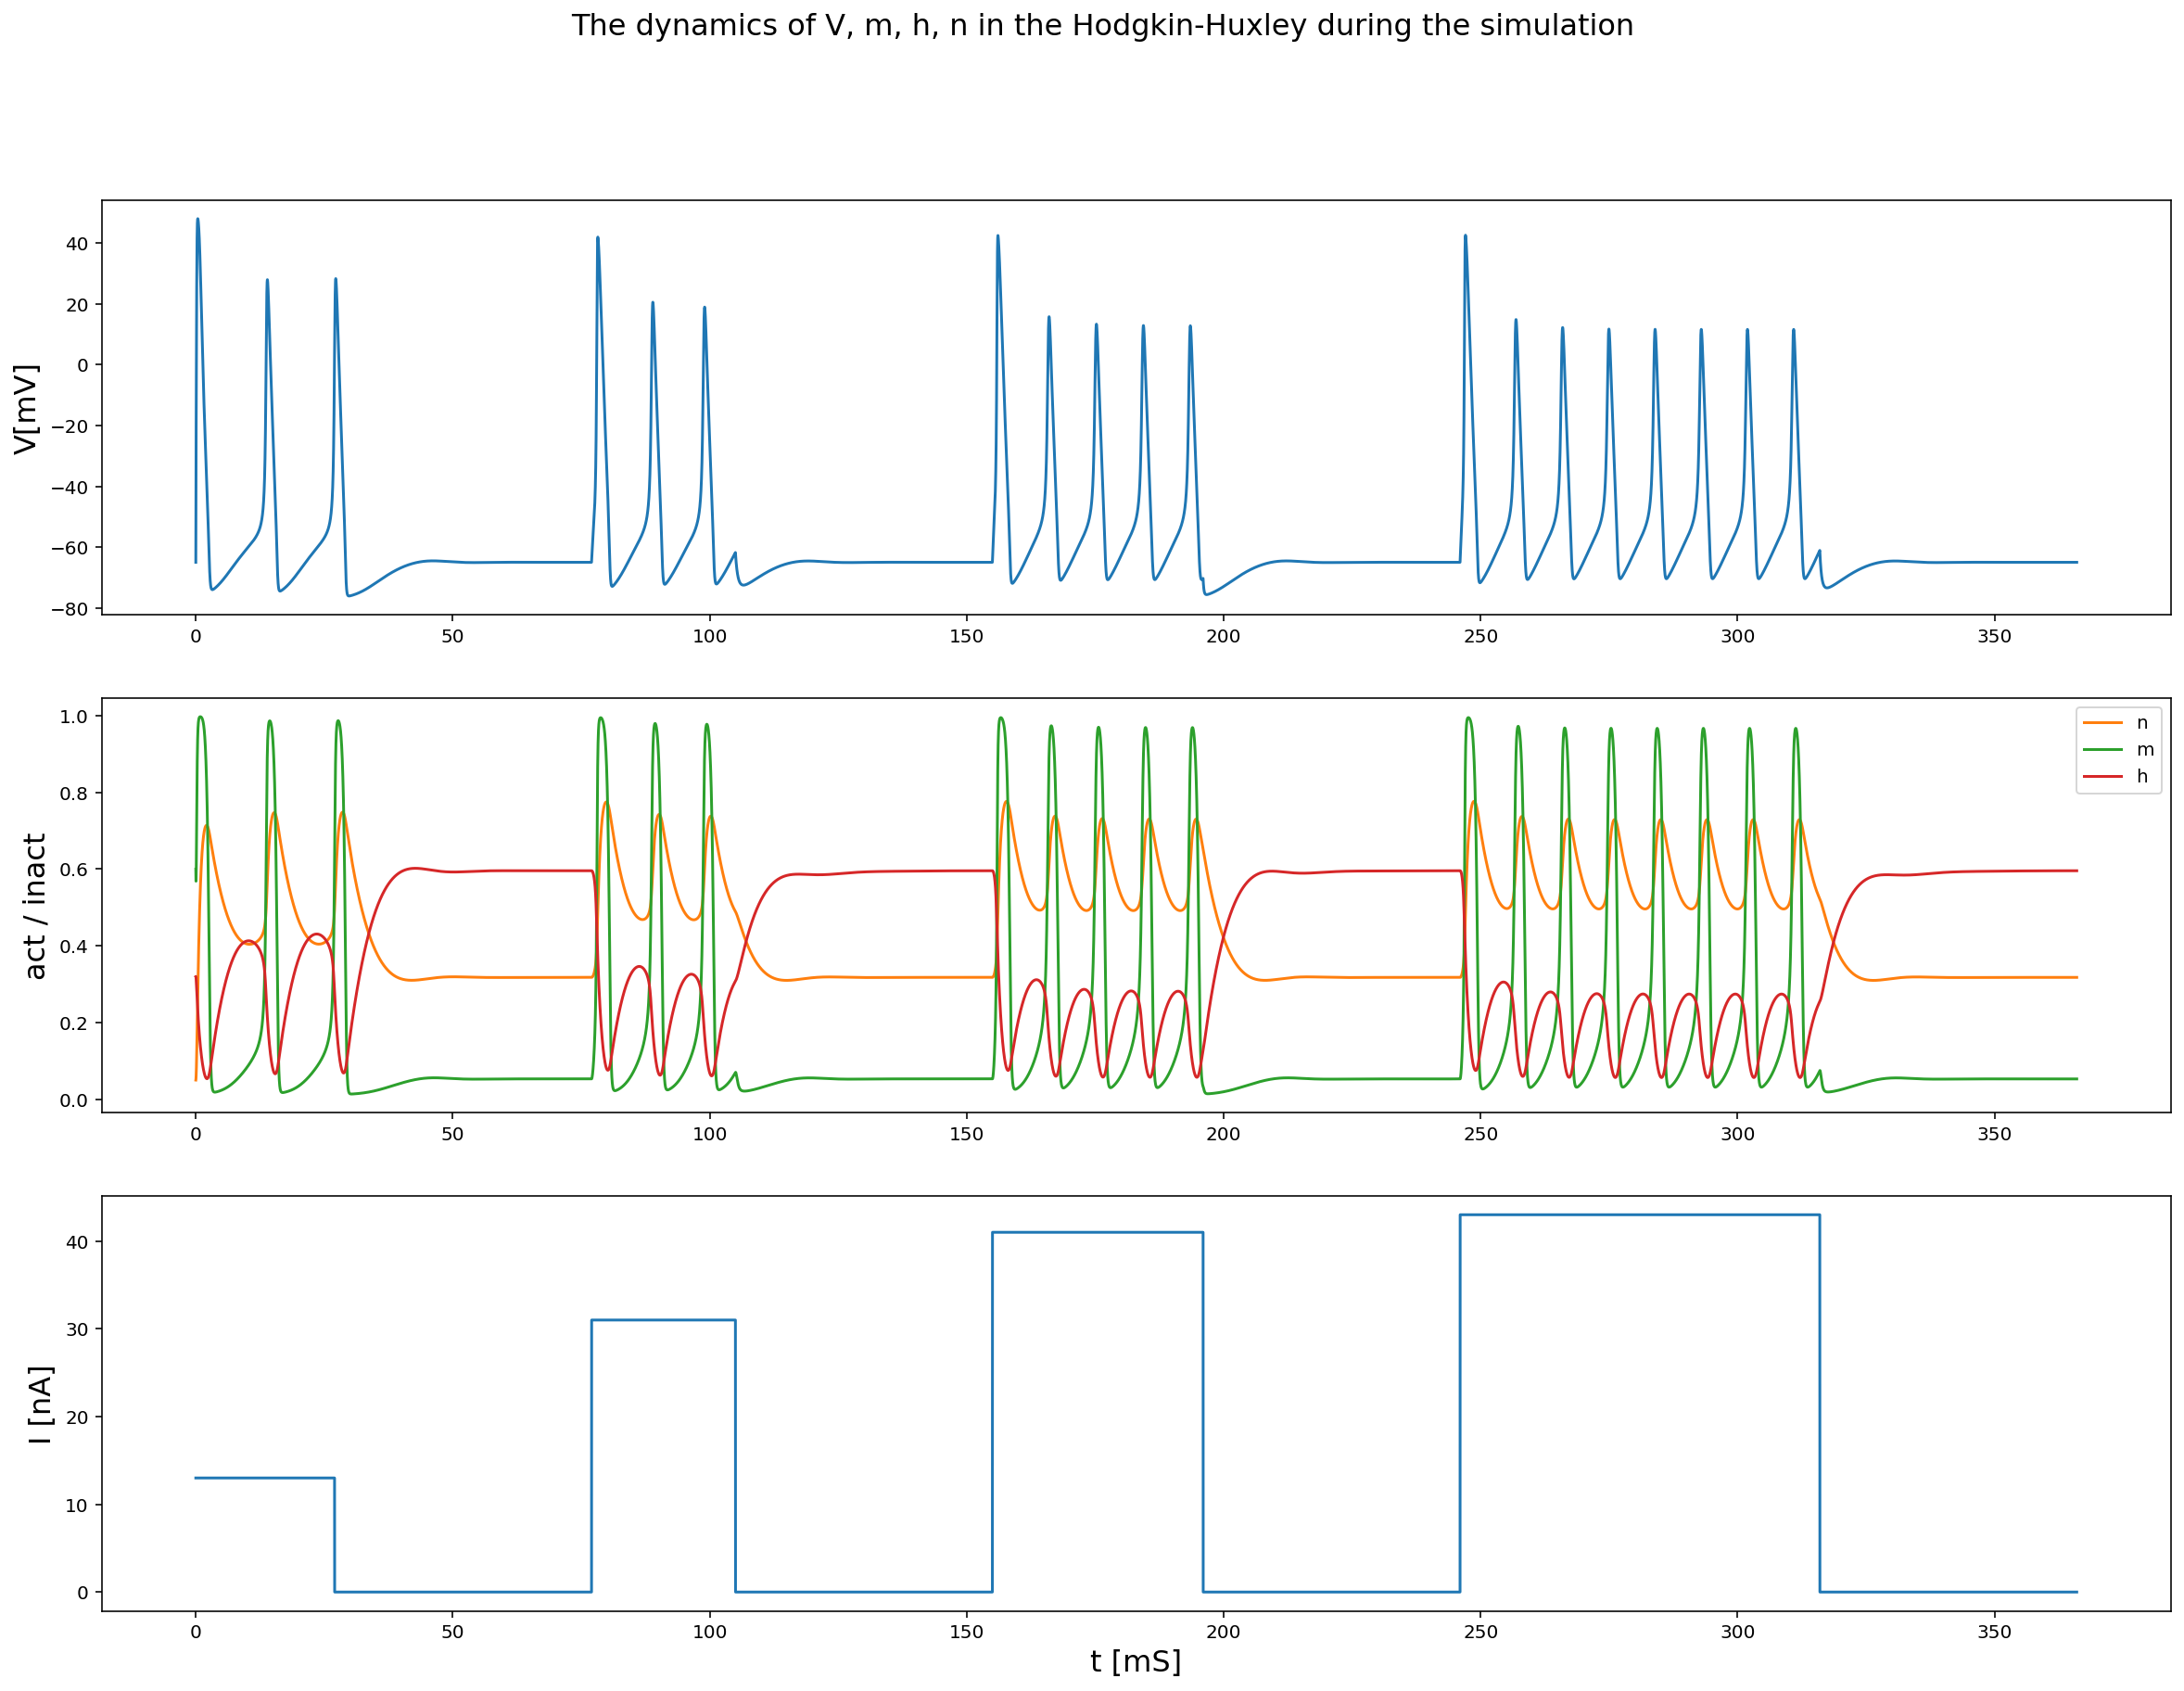

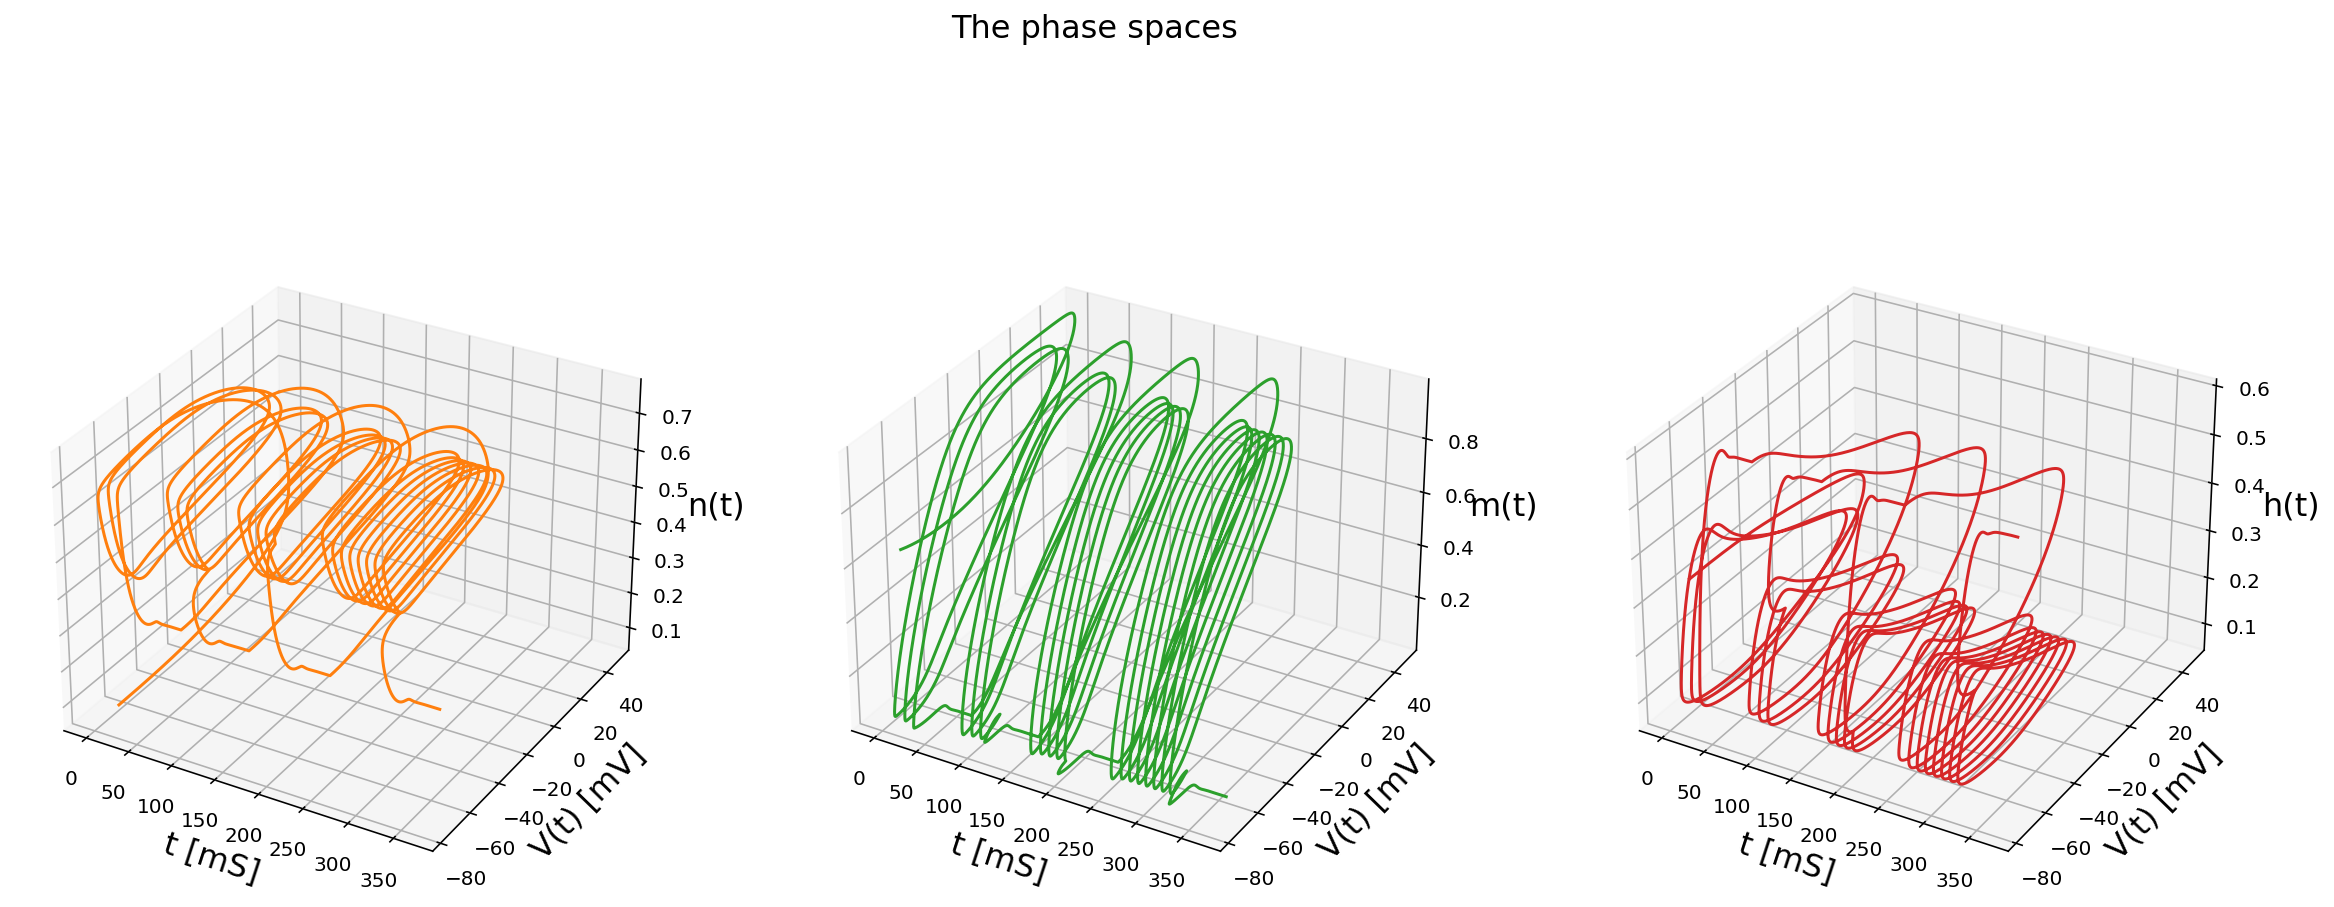

In [5]:
t, I_t, I_inj = init_simulation(n_currents=4)
model = Hodgkin_Huxley_Model(t_range=t,
                             I_e = I_inj)
sol = model.solve_system()
visulize_simulation(sol, t, I_t)

### Simulation 2:

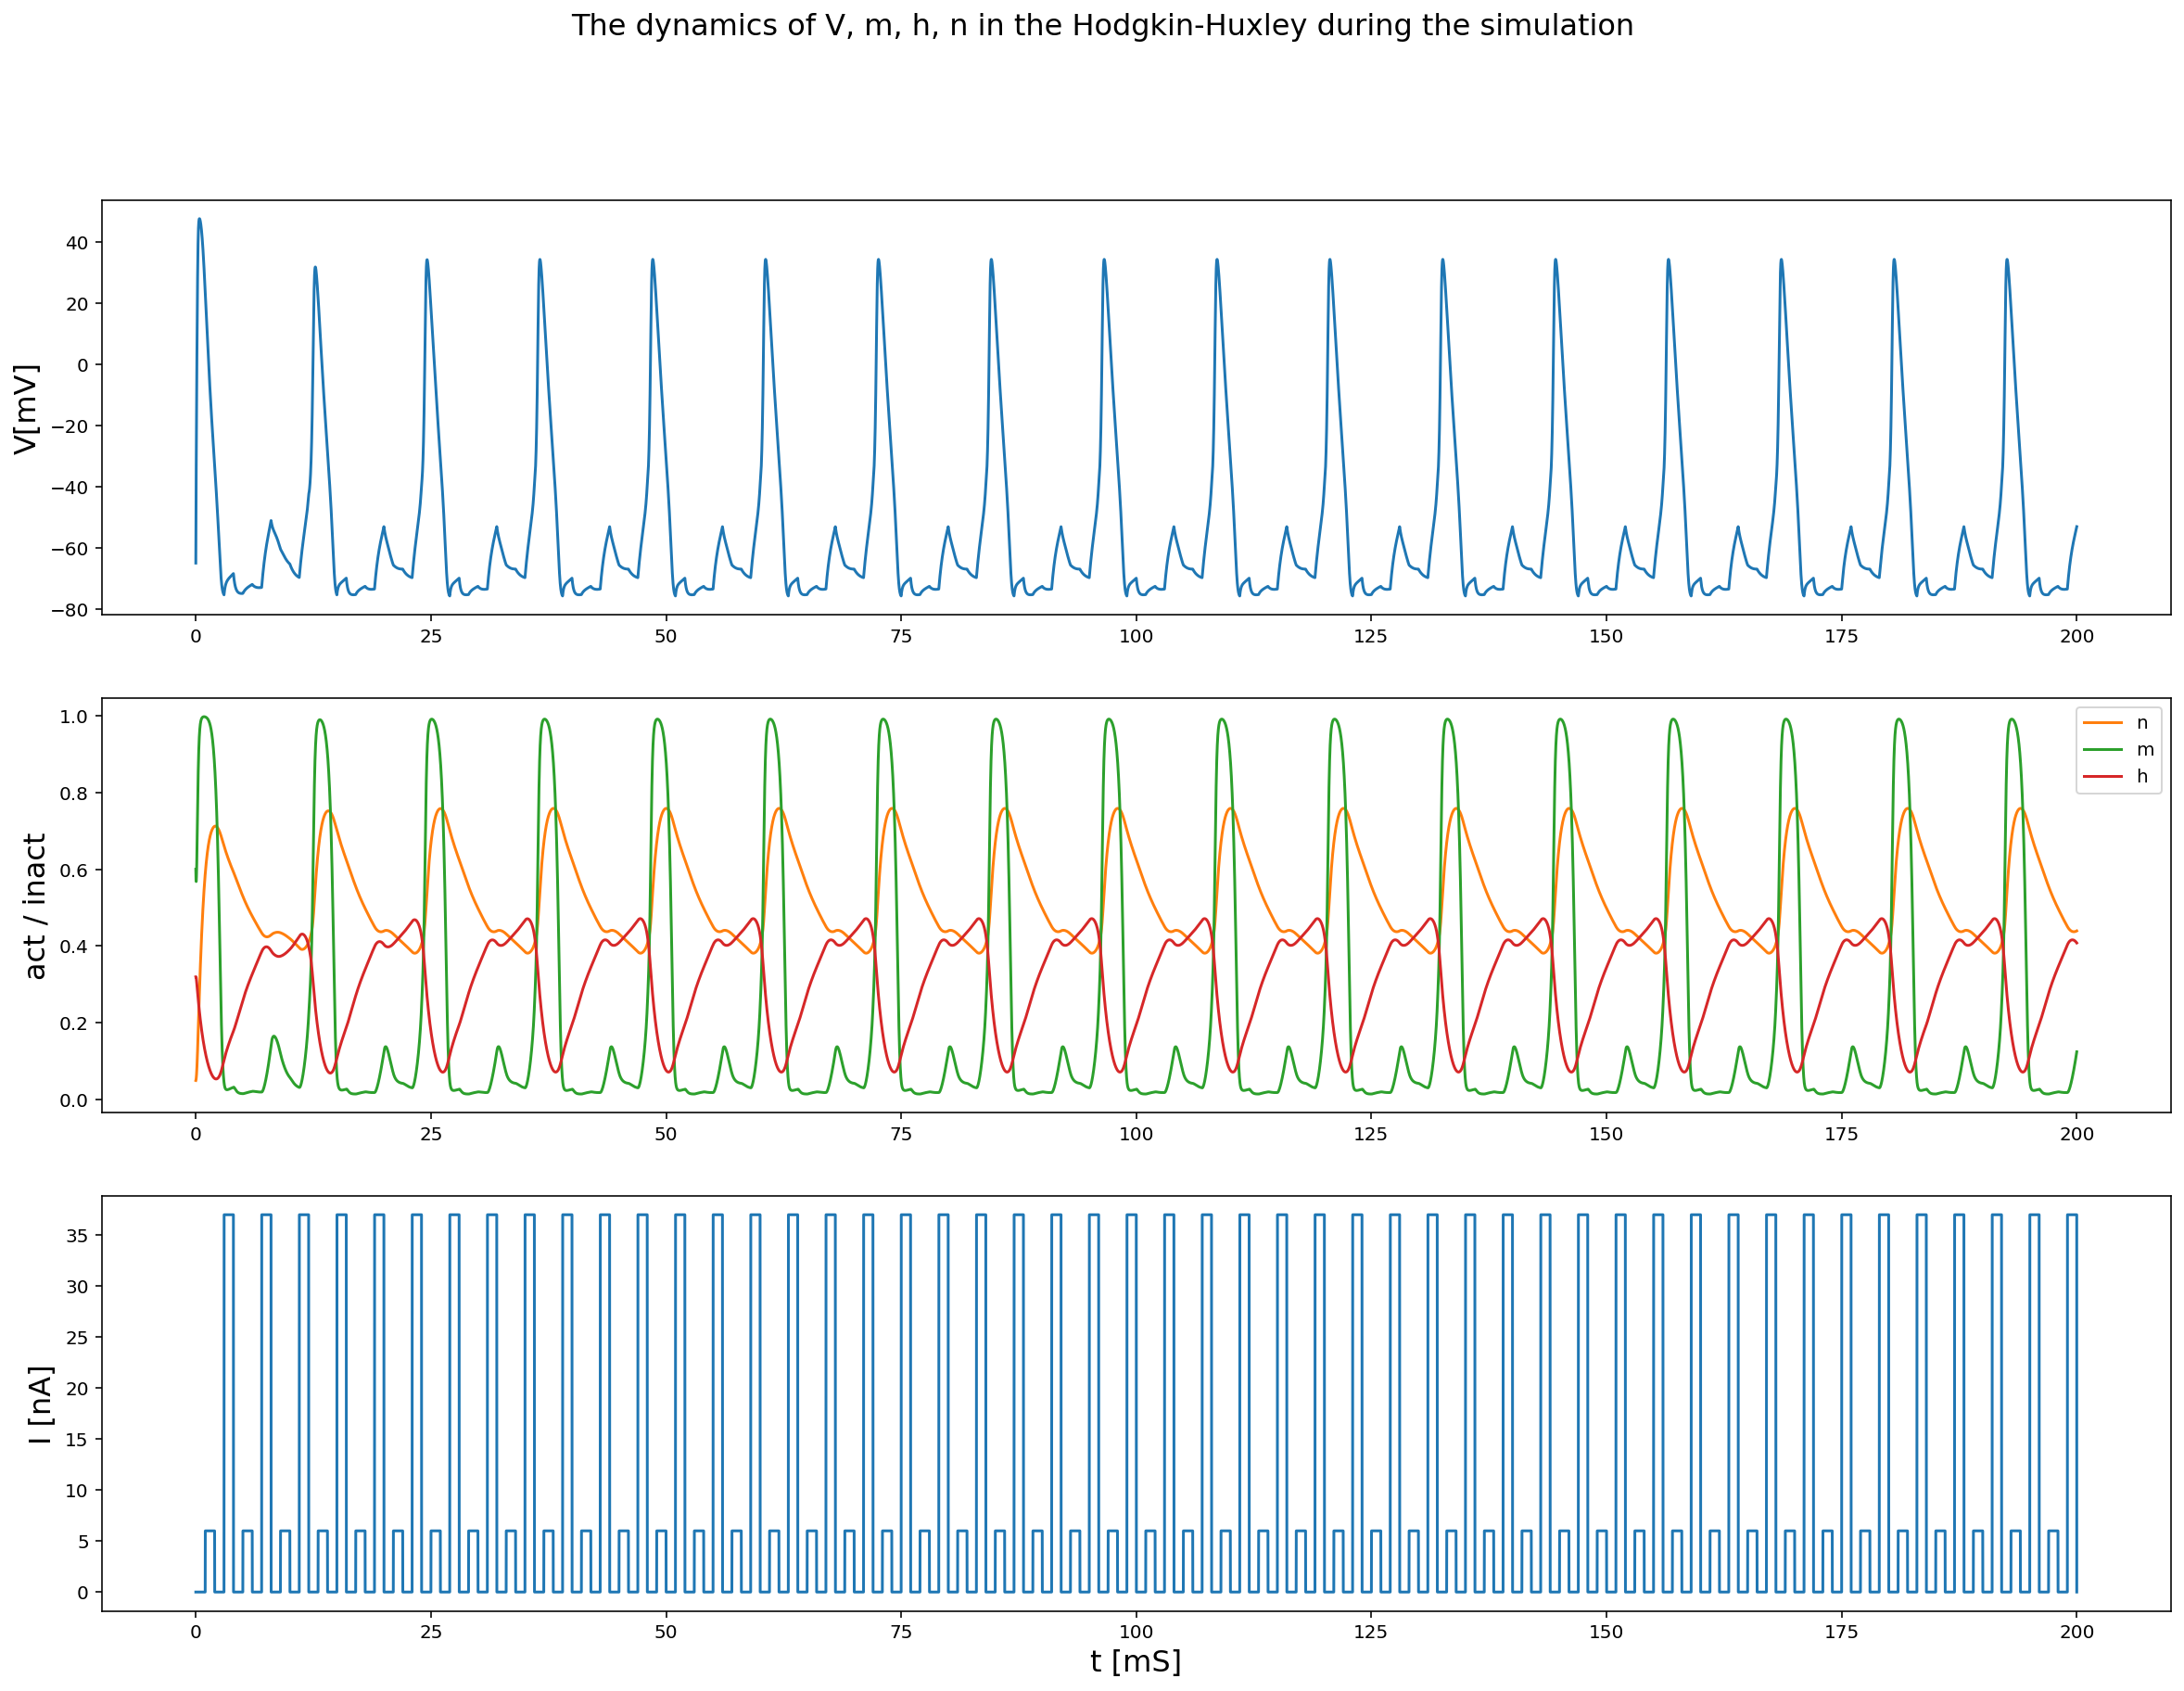

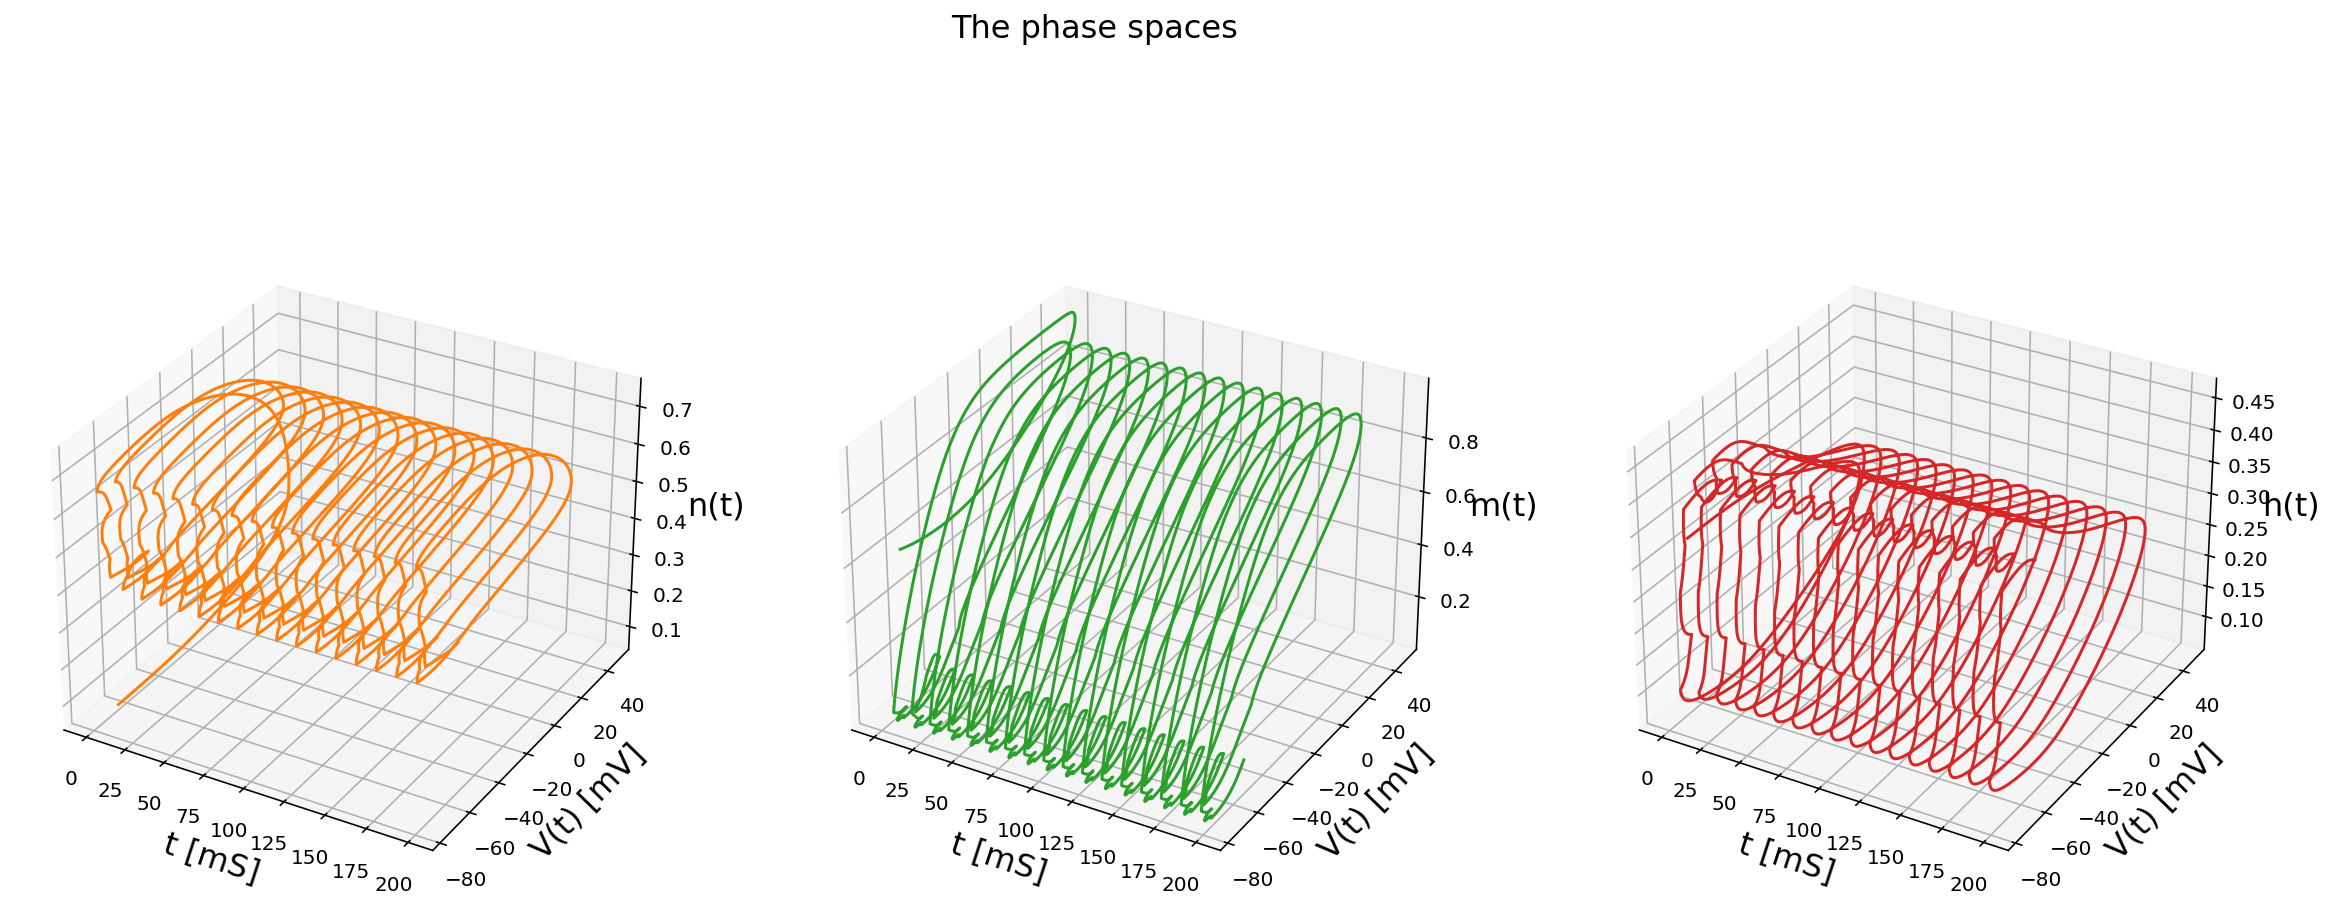

In [6]:
t, I_t, I_inj = init_simulation(n_currents=2)
model = Hodgkin_Huxley_Model(t_range=t,
                             I_e = I_inj)
sol = model.solve_system()
visulize_simulation(sol, t, I_t)

### Анализ:
* 1) Амплитуда Vm практически не зависит от амплитуды возбуждающего импульса. Дейяствуя по принципу «все или ничего», ипульс либо появляется, либо нет. 
* 2) Величина тока возбуждения влияет на число спаек - чем она больше, тем больше их возникает во время подачи тока. 
* 3) По графикам 1-ой симуляции видно, что для каждого промежутка существуют предельные циклы каждого фазового пространства.